<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [2]:
import numpy as np
import pandas as pd


from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

from sklearn.model_selection import train_test_split
import skimage
from skimage.transform import resize
import skimage.io

import os
import wget
import tarfile
from tqdm.notebook import tqdm
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "cpu"
print(device)


cuda


## Скаичваем DataSet картинок

In [143]:
# # !pip install wget
url = "http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz"
output_directory = !cd
output_directory = output_directory[0]
filename = wget.download(url, out=output_directory)
filename

In [144]:
# open file
file = tarfile.open(filename)
# extracting file
file.extractall(output_directory)
file.close()


In [145]:
url = "http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt"
filename = wget.download(url, out=output_directory)
filename

In [286]:
imgsize = 64

In [146]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [148]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
# from get_dataset import fetch_dataset
data, attrs = fetch_dataset(dimx=imgsize, dimy=imgsize)

In [251]:
data.shape, attrs.shape

((13143, 64, 64, 3), (13143, 73))


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [264]:
batch_size = 20
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs, train_size=0.9, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_photos, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=batch_size)

### Выводим первые 5 картинок

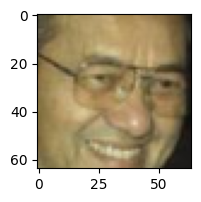

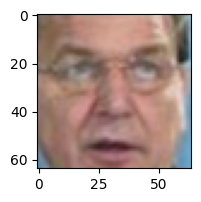

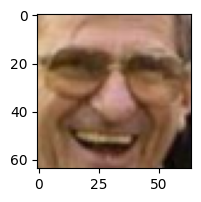

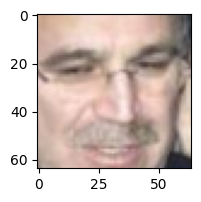

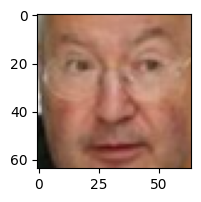

In [155]:
for i in range(5):
    plt.figure(figsize=(2,2))
    plt.imshow(train_photos[i])
    plt.show()

# Автоэнкодер

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [300]:
class Autoencoder(torch.nn.Module):
  def __init__(self, channels_size=8):
    super().__init__()
    
    self.conv_encoder = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=channels_size*2, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(channels_size*2),
        nn.Conv2d(in_channels=channels_size*2, out_channels=channels_size*4, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(channels_size*4),
        nn.Conv2d(in_channels=channels_size*4, out_channels=channels_size*8, kernel_size=3, padding=1),
    )

    self.conv_decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels=channels_size*8, out_channels=channels_size*4, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=channels_size*4, out_channels=channels_size*2, kernel_size=3,padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=channels_size*2, out_channels=3, kernel_size=3, padding=1),
    )
  def forward(self, x):
    x = x.permute(0, 3, 1, 2)
    latent = self.conv_encoder(x)
    reconstructed = self.conv_decoder(latent)
    reconstructed = torch.sigmoid(reconstructed)
    reconstructed = reconstructed.permute(0, 2, 3, 1)
    return reconstructed

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

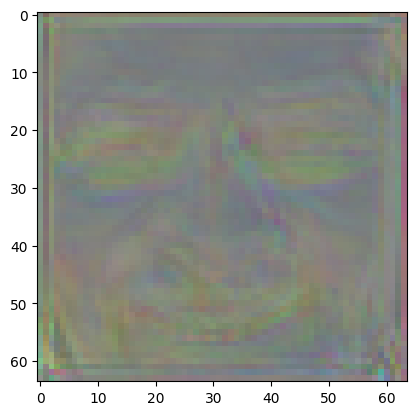

  0%|          | 0/592 [00:00<?, ?it/s]

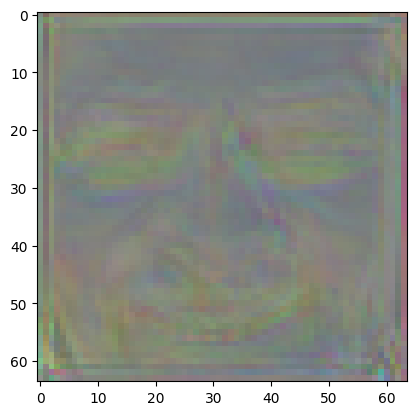

  0%|          | 0/592 [00:00<?, ?it/s]

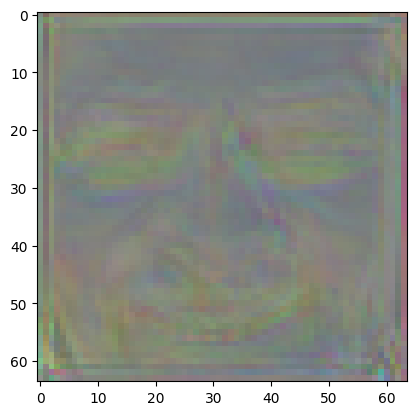

  0%|          | 0/592 [00:00<?, ?it/s]

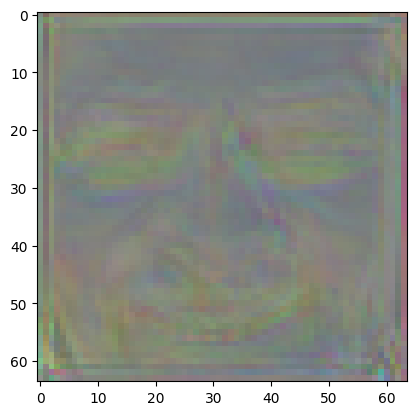

  0%|          | 0/592 [00:00<?, ?it/s]

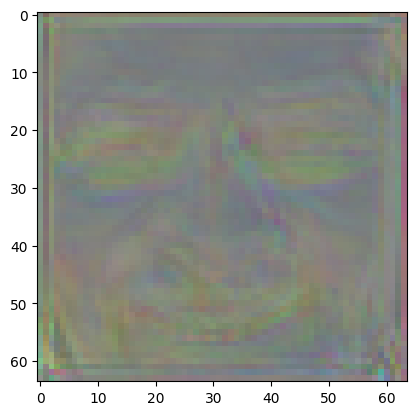

  0%|          | 0/592 [00:00<?, ?it/s]

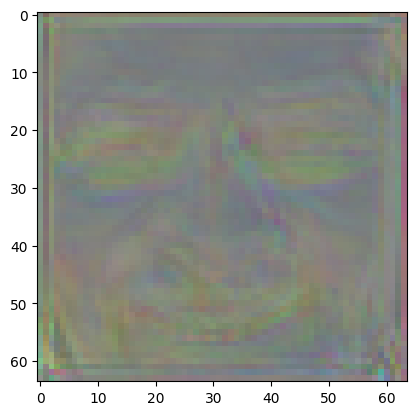

  0%|          | 0/592 [00:00<?, ?it/s]

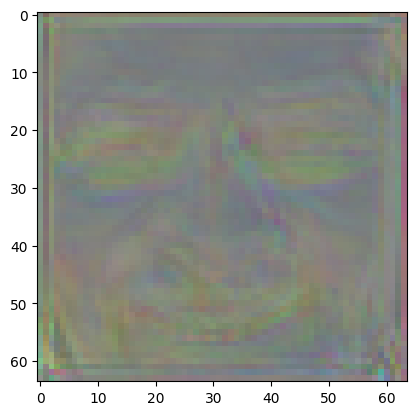

  0%|          | 0/592 [00:00<?, ?it/s]

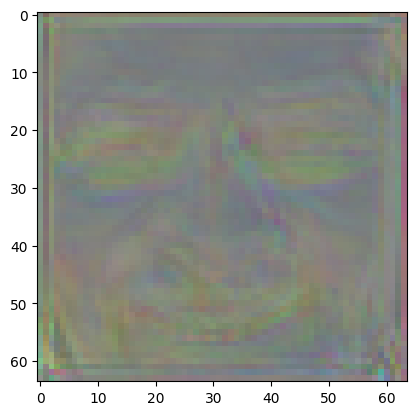

  0%|          | 0/592 [00:00<?, ?it/s]

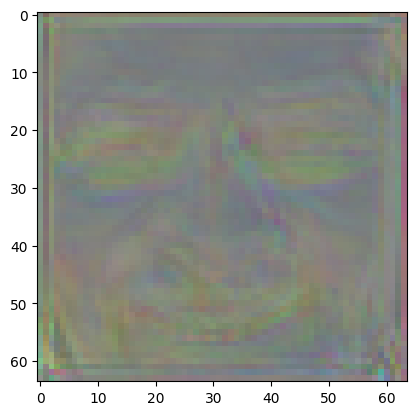

  0%|          | 0/592 [00:00<?, ?it/s]

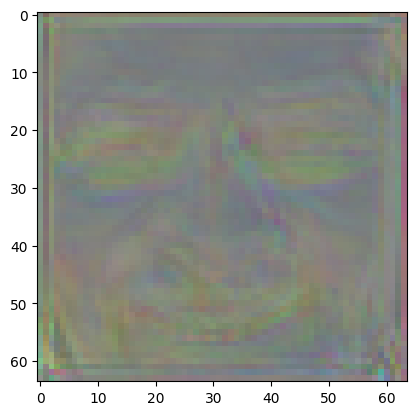

In [304]:
max_epochs = 10
model = Autoencoder(channels_size=8).to(device)
optimaizer = optim.Adam(model.parameters())
loss_fn = F.mse_loss

history = []

for epoch in tqdm(range(max_epochs)):
    model.train()
    train_losses = 0
    mae_train_losses = 0
    reconstruction = []
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        reconstruction = model(batch.to(device).float())
        loss = loss_fn(reconstruction.float(), batch.to(device).float())
        mae_loss = nn.L1Loss()(reconstruction.float(), batch.to(device).float())

        loss.backward()
        optimizer.step()
        train_losses += loss.item()
        mae_train_losses += mae_loss
    train_losses = train_losses/len(train_loader)
    mae_train_losses = mae_train_losses/len(train_loader)
    # Отображаем последнее изборажение
    plt.imshow(reconstruction[1].detach().cpu())
    plt.show()    
    
    model.eval()
    val_losses = 0
    mae_val_losses = 0
    with torch.no_grad():
        for batch in val_loader:
            reconstruction = model(batch.to(device).float())
            val_loss = loss_fn(reconstruction.float(), batch.to(device).float())
            val_mae_loss = nn.L1Loss()(reconstruction.float(), batch.to(device).float())
            val_losses += val_loss.item()
            mae_val_losses += val_mae_loss
    val_losses = val_losses / len(val_loader)
    mae_val_losses = mae_val_losses / len(val_loader)

            
    history.append((train_losses, val_losses, mae_train_losses.item(), mae_val_losses.item()))


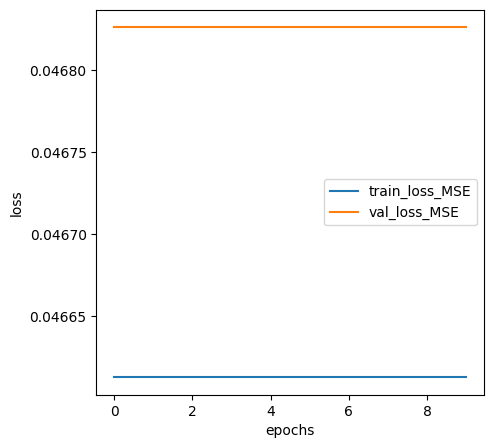

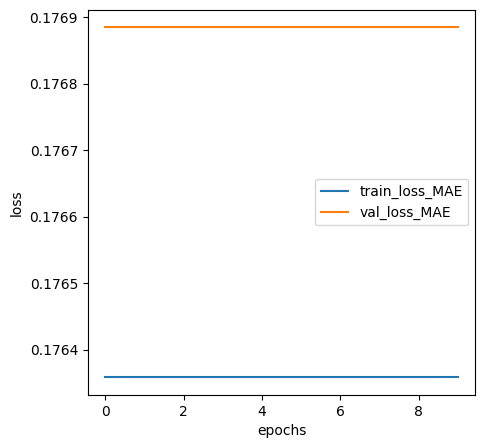

In [305]:
mse_loss, val_mse_loss, mae_loss, val_mae_loss = zip(*history)
plt.figure(figsize=(5, 5))
plt.plot(mse_loss, label="train_loss_MSE")
plt.plot(val_mse_loss, label="val_loss_MSE")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


plt.figure(figsize=(5, 5))
plt.plot(mae_loss, label="train_loss_MAE")
plt.plot(val_mae_loss, label="val_loss_MAE")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Вывод:
Сделан автоэнкодер с экспириментами со сверточными слоями. Использовались фотографии людей. Замерялись два лосса MAE и MSE. В конце каждой эпохи выводится восстановленное изображение.
Не получилось сделать приемлимую модель. Вероятно для работы с фото через простой автоэнкодер требуются гораздо более мощные сети и железо. На более простых данных как в семинаре автоэнкодер показал себя лучше.

# Следующий шаг
Часть ДЗ не была сделана. В том числе повлияла длительность обучения без GPU (или с GPU но с очень маленькой памятью)
Сделана VAE-модель с использованием сверточных слоев, в качестве датасета использовались также фото лиц и также сделана подставновка случайного нормального распределения на обученную VAE-модель. Что показало лучше результат чем на семинаре

# Часть 2: Variational Autoencoder (10 баллов) 

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [306]:
features = 2024
img_size = 64
class VarAutoencoder(nn.Module):
    def __init__(self,channels_size=8):
        super().__init__()
        self.channels_size = channels_size
        self.max_pool = nn.MaxPool2d(kernel_size=2) # 256 -> 128
        
        self.enc_conv0 = nn.Sequential(
                            nn.Conv2d(in_channels=3, out_channels=channels_size, kernel_size=3, padding=1),
                            nn.ReLU(),
                            
                        )
        
        self.enc_conv1 = nn.Sequential(
                            nn.Conv2d(in_channels=channels_size, out_channels=channels_size*2, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(channels_size*2),
            
                            nn.Conv2d(in_channels=channels_size*2, out_channels=channels_size*2, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(channels_size*2),
                        )
        self.enc_conv2 = nn.Sequential(
                            nn.Conv2d(in_channels=channels_size*2, out_channels=channels_size*4, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(channels_size*4),
            
                            nn.Conv2d(in_channels=channels_size*4, out_channels=channels_size*4, kernel_size=3, padding=1),
                            nn.ReLU(),
                            nn.BatchNorm2d(channels_size*4),
            
                            nn.Conv2d(in_channels=channels_size*4, out_channels=channels_size*4, kernel_size=3, padding=1),
                        )
        
        self.flatten = nn.Flatten()
        
        # decoder (upsampling)
        self.unmax_pool = nn.MaxUnpool2d(kernel_size=2)
        self.conv_transp_stride2 = nn.ConvTranspose2d(in_channels=channels_size*4, out_channels=channels_size*2, kernel_size=3, output_padding =0, padding=1)
        self.conv_transp_stride1 = nn.ConvTranspose2d(in_channels=channels_size*2, out_channels=channels_size, kernel_size=3, output_padding =0, padding=1)
        self.conv_transp_stride0 = nn.ConvTranspose2d(in_channels=channels_size, out_channels=3, kernel_size=3, output_padding =0, padding=1)
        self.conv_result = nn.Conv2d(in_channels=channels_size*4, out_channels=3, kernel_size=3, padding=1)
        
        self.upsample2 = nn.Sequential(
                            nn.Conv2d(in_channels=channels_size*4, out_channels=channels_size*2, kernel_size=3, padding=1),
                            nn.BatchNorm2d(channels_size*2),
                            nn.ReLU(),
            
                            nn.Conv2d(in_channels=channels_size*2, out_channels=channels_size*2, kernel_size=3, padding=1),
                            nn.BatchNorm2d(channels_size*2),  
                            nn.ReLU(),
            
                            nn.Conv2d(in_channels=channels_size*2, out_channels=channels_size*2, kernel_size=3, padding=1),
                            nn.BatchNorm2d(channels_size*2),
                            nn.ReLU(),
                        )
        
        self.upsample1 = nn.Sequential(
                            nn.Conv2d(in_channels=channels_size*2, out_channels=channels_size, kernel_size=3, padding=1),
                            nn.BatchNorm2d(channels_size),
                            nn.ReLU(),
            
                            nn.Conv2d(in_channels=channels_size, out_channels=channels_size, kernel_size=3, padding=1),
                            nn.BatchNorm2d(channels_size),  
                            nn.ReLU(),
            
                        )
        
        self.upsample0 = nn.Sequential(
                            nn.Conv2d(in_channels=channels_size, out_channels=1, kernel_size=3, padding=1),
                            nn.BatchNorm2d(1),
                            nn.ReLU(),
            
                            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1),
                        )

        # encoder
        self.liner_encoder = nn.Sequential(
            nn.Linear(in_features=channels_size*4*img_size, out_features=features*2),

        )
 
        # decoder 
        self.liner_decoder = nn.Sequential(
            nn.Linear(in_features=features, out_features=channels_size*4*img_size*img_size),
            
        )
        
    def encoder(self, x):
        # encoder
        encoder0 = self.max_pool(self.enc_conv0(x))
        encoder1 = self.max_pool(self.enc_conv1(encoder0))
        encoder2 = self.max_pool(self.enc_conv2(encoder1))
        return encoder2
    
    def decoder(self, x):
        x_decoder2 = self.conv_transp_stride2(x)
        x_decoder1 = self.conv_transp_stride1(x_decoder2)
        x_decoder0 = self.conv_transp_stride0(x_decoder1)
        return x_decoder0
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5 * log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
    
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x_encoder = self.encoder(x.float())
        x_flatten = self.flatten(x_encoder)
        x_liner_encoder = self.liner_encoder(x_flatten)
        x_liner_encoder = x_liner_encoder.view(-1, 2, features)
        
        # get `mu` and `log_var`
        mu = x_liner_encoder[:, 0, :] # the first feature values as mean
        log_var = x_liner_encoder[:, 1, :] # the other feature values as variance
        z = self.reparameterize(mu, log_var)
        z_liner_decoder = self.liner_decoder(z)
        z_liner_decoder = z_liner_decoder.view(-1, self.channels_size*4, 64, 64)
        x_decoder = self.decoder(z_liner_decoder)
        
        x_decoder = torch.sigmoid(x_decoder)
        x_decoder = x_decoder.permute(0, 2, 3, 1)
        return x_decoder, mu, log_var


Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [307]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/592 [00:00<?, ?it/s]

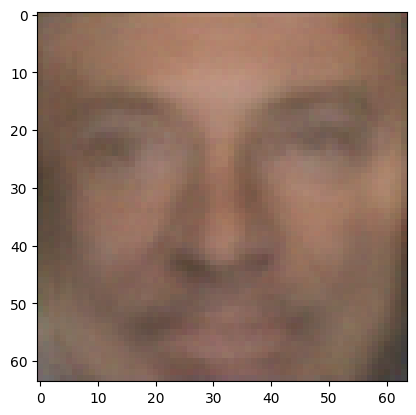

  0%|          | 0/592 [00:00<?, ?it/s]

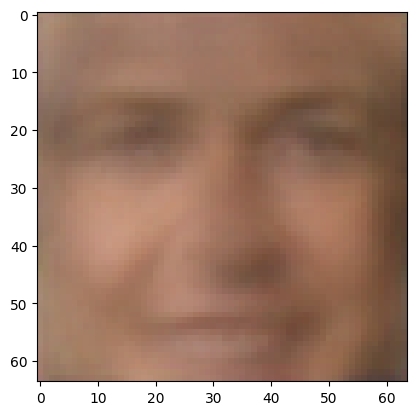

[(0.046612950255842625, 0.04682616302461335, 0.17635850608348846, 0.17688488960266113), (0.046612950255842625, 0.04682616302461335, 0.17635850608348846, 0.17688488960266113), (0.046612950255842625, 0.04682616302461335, 0.17635850608348846, 0.17688488960266113), (0.046612950255842625, 0.04682616302461335, 0.17635850608348846, 0.17688488960266113), (0.046612950255842625, 0.04682616302461335, 0.17635850608348846, 0.17688488960266113), (0.046612950255842625, 0.04682616302461335, 0.17635850608348846, 0.17688488960266113), (0.046612950255842625, 0.04682616302461335, 0.17635850608348846, 0.17688488960266113), (0.046612950255842625, 0.04682616302461335, 0.17635850608348846, 0.17688488960266113), (0.046612950255842625, 0.04682616302461335, 0.17635850608348846, 0.17688488960266113), (0.046612950255842625, 0.04682616302461335, 0.17635850608348846, 0.17688488960266113), (2930.735721072635, 168821.04865056818, 0.002643396146595478, 0.1688511222600937), (2726.2640677787163, 166307.0848721591, 0.0020

In [312]:
device = "cpu"
n_epochs = 2
criterion = loss_vae
autoencoder = VarAutoencoder()
autoencoder.to(device)
optimizer = optim.Adam(autoencoder.parameters())
for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    train_losses = 0
    mae_train_losses = 0    
    i = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        reconstruction, mu, logsigma = autoencoder(batch.to(device).float())

        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
        mae_loss = nn.L1Loss()(reconstruction.float(), batch.to(device).float())
        train_losses += loss.item()
        mae_train_losses += mae_loss
        
        loss.backward()
        optimizer.step()
    train_losses = train_losses/len(train_loader)
    mae_train_losses = mae_train_losses/len(train_loader)

    autoencoder.eval()
    val_losses = 0
    mae_val_losses = 0
    with torch.no_grad():
        for batch in val_loader:
            reconstruction, mu, logsigma = autoencoder(batch.to(device))
            reconstruction = reconstruction
            val_loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
            val_mae_loss = nn.L1Loss()(reconstruction.float(), batch.to(device).float())
            val_losses += val_loss.item()
            mae_val_losses += val_mae_loss
    val_losses = val_losses / len(val_loader)
    mae_val_losses = mae_val_losses / len(val_loader)

    plt.imshow(reconstruction[0].detach().cpu())
    plt.show() 
    history.append((train_losses, val_losses, mae_train_losses.item(), mae_val_losses.item()))


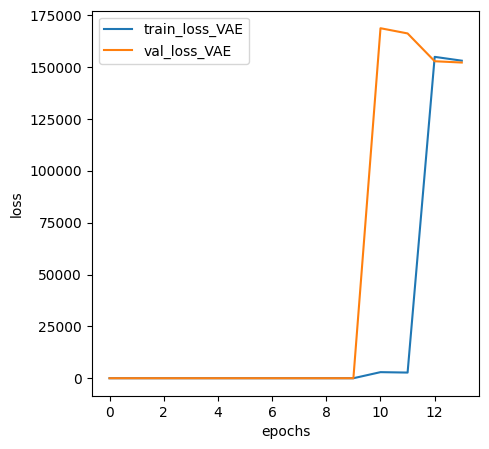

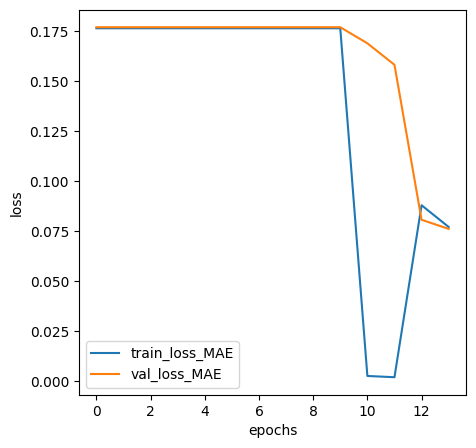

In [314]:
vae_loss, val_vae_loss, mae_loss, val_mae_loss = zip(*history)
plt.figure(figsize=(5, 5))
plt.plot(vae_loss, label="train_loss_VAE")
plt.plot(val_vae_loss, label="val_loss_VAE")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


plt.figure(figsize=(5, 5))
plt.plot(mae_loss, label="train_loss_MAE")
plt.plot(val_mae_loss, label="val_loss_MAE")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
Лоссы конечно не показательные из-за использования всего двух эпох.
Но важно, что сеть с использованием сверточных слоев показала себя лучше чем только линейные слои (как) на семинаре. 
Преимущества использования в автоэнкодере сверточных слоев особено видны при генерации изборажений из случайного нормального распределения (ниже в блокноте).   

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

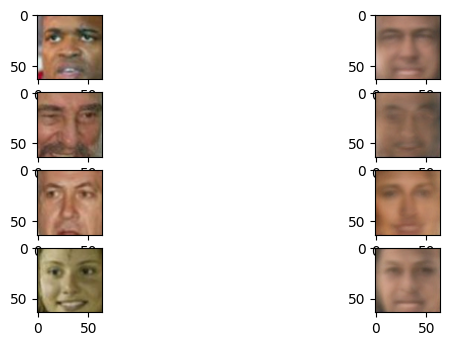

In [323]:
# Рассчитываем генерацию на обученное автоенкодер-модели для N картинок
N = 4
autoencoder.eval()
with torch.no_grad():
  for i, batch in enumerate(val_loader):
    reconstruction, mu, logsigma = autoencoder(batch.to(device))
    result = reconstruction.cpu().detach().numpy()
    ground_truth = batch.numpy()
    if i*batch_size >= N:
        break

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:N], result[:N])):
  plt.subplot(20, 2, 2*i+1)
  plt.imshow(gt)
  plt.subplot(20, 2, 2*i+2)
  plt.imshow(res)

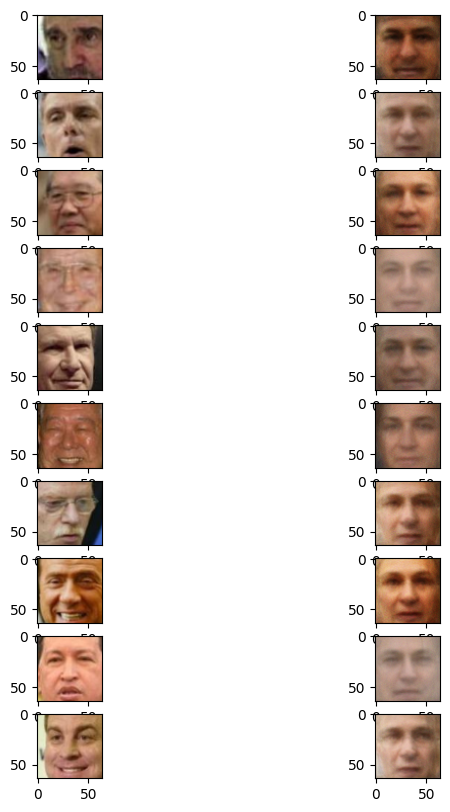

In [161]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:20], result[:20])):
  plt.subplot(20, 2, 2*i+1)
  plt.imshow(gt)
  plt.subplot(20, 2, 2*i+2)
  plt.imshow(res)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [345]:
# Забыл изначально sampler в класс autoencoder вставить, а обучать времени и мощностей нет,
# поэтому вышел из ситуации следущим способом, просто создал независимый от класса метод 
def autoencoder_sampler(model, z):
    z_liner_decoder = model.liner_decoder(z)
    z_liner_decoder = z_liner_decoder.view(-1, model.channels_size*4, 64, 64)
    x_decoder = model.decoder(z_liner_decoder)
    x_decoder = torch.sigmoid(x_decoder)
    x_decoder = x_decoder.permute(0, 2, 3, 1)
    return x_decoder

In [348]:
# генерируем случайные распределения
z = np.array([np.random.normal(0, 1, features) for i in range(batch_size)])
output = autoencoder_sampler(autoencoder, torch.FloatTensor(z).to(device))
output.shape

torch.Size([20, 64, 64, 3])

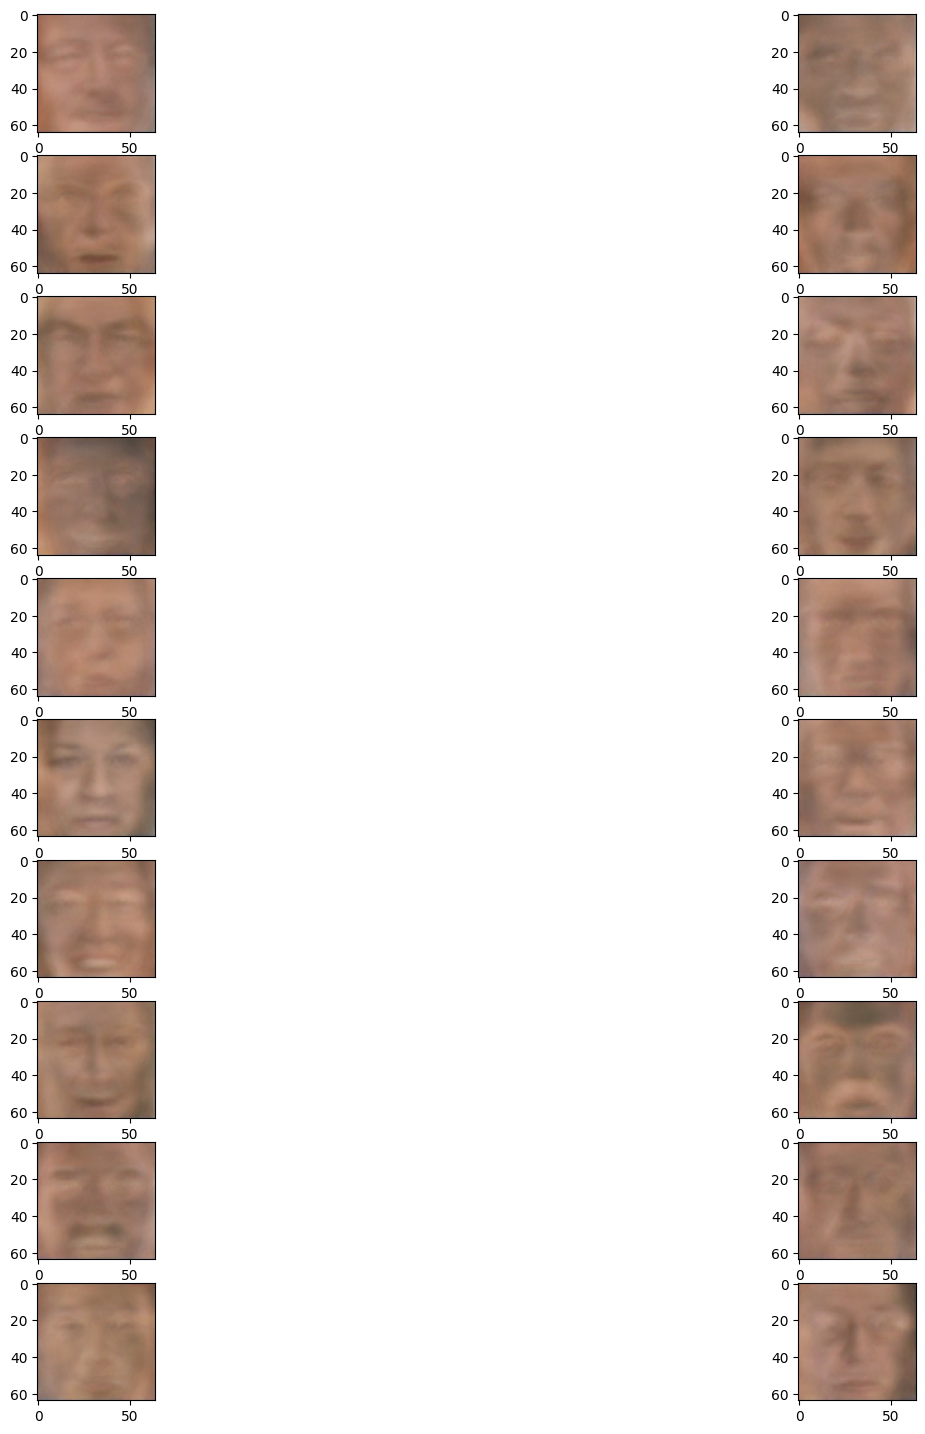

In [347]:
plt.figure(figsize=(18, 18))
for i in range(output.shape[0]):
  plt.subplot(output.shape[0] // 2, 2, i + 1)
  generated = output[i].cpu().detach().numpy()
  plt.imshow(generated)

plt.show()

### Итог
Генерация изображений из случайного латентного пространства у модели с 2 эпохами но со сверточными слоями получилась лучеш чем на семинаре с 50 эпохами но без сверточных слоев